# ANLP 2020 - Assignment 3

*Raza Ali, 805145* 

<div class="alert alert-block alert-danger">Due: Wednesday, January 20, 2021, 23:59</div>

<div class="alert alert-block alert-info">

**NOTE**
<br>

Please first fill in your name and id number at the top of the assignment, and **rename** the assignment file to **yourlastname-anlp-3.ipynb**<br><br>
Problems and questions are given in blue boxes like this one. All grey and white boxes marked by the comment "#student solution/discussion here" must be filled by you (they either require code or a (brief!) discussion). <br><br>
Please hand in your assignment by the deadline via Moodle. In case of questions, you can contact the TAs and the instructors via the usual channels.

</div>

<div class="alert alert-block alert-info">
    
In this assignment, you will implement an LSTM model and train it to generate text, one character at a time. (So note: We're asking you to create a character-level model; in the lectures, we've so far only seen word-level models. Think about what the difference is, and what its practical consequences are.)

For training, we prepared two text files (train and test) containing passages from Charles Dickens' novels (dickens_train.txt, dickens_test.txt).

You should use the PyTorch machine learning library to implement this exercise.

- Instructions to install PyTorch can be found here: <http://pytorch.org/>
- The introductory tutorial we prepared for PyTorch is attached to the assignment: pytorch_lecture_2019.ipynb
- Some PyTorch examples for an in depth overview: <https://github.com/jcjohnson/pytorch-examples>
- Another common quickstart tutorial is this [PyTorch 60 Minutes Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)

(But don't get carried away: For this assignment, you mostly need the very straightforward elements from the `nn` module in PyTorch that implement the layers that you've learned about, such as RNNS, LSTMs, embeddings.)

This assignment is designed to be runnable on a decent CPU. With 2 layers LSTM and hidden size of 128, it takes ~20 minutes to train while with hidden size of 512, it takes ~2 hours. Please take this into consideration while doing this assignment. 

Alternatively you can also use Google Colab <https://colab.research.google.com/> by uploading your notebook there, which gives you access to a GPU. (Check that you are indeed using the GPU, via `print(torch.cuda.is_available()`.) However, please keep mind as there is limitation for the free edition (i.e. 'maximum lifetime' of 12 hours).


The goal of this assignment is to get you to specify a simple network, and play around with its hyperparameters to explore how they affect the output. This is why we're providing you with a lot of code, to ensure that the basic housekeeping is taken care of.

</div>

# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`). (What do you think is the use of this step?)

In [1]:
!pip install unidecode

     |████████████████████████████████| 245kB 14.8MB/s 


In [13]:
import unidecode
import string
import random
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


all_characters = string.printable
n_characters = len(all_characters)


file = unidecode.unidecode(open('dickens_train.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 1136673


To make inputs out of this big string of data, we will be splitting it into chunks.

In [4]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len -1) 
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

he heavy 
stick had descended smartly.

'Let him be!' said this man in a suppressed voice, as they 
struggled together on the grass.  'Fair play!  His is the build of 
a girl to mine, and he's got a we


# Build the Model (30 points)

<div class="alert alert-block alert-info">

The model that you are asked to build will take as input characters up to step $t-1$ and is expected to produce a distribution over characters at step $t$ (which can then be used to sample one character from that distribution). 

There are three layers: one layer that maps the input character into its embedding, one LSTM layer (which may itself have multiple layers) that operates on that embedding and a hidden and cell state, and a decoder layer that outputs the probability distribution.

The beauty of frameworks such as PyTorch is that you can express this pretty directly in code, adding (pre-defined) layers to your network.
</div>

In [5]:
#student solution/discussion here

import torch
import torch.nn as nn
#you can import additional libraries if needed.

# Here is a pseudocode to help with your LSTM implementation. 
# You can add new methods and/or change the signature (i.e., the input parameters) of the methods.
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers,emb_dim = 50):
      super(LSTM, self).__init__()
      self.input_size = input_size
      self.num_layers = num_layers
      self.hidden_size = hidden_size
      self.output_size = output_size
      self.batch_size = 1
      #self.emb_dim = emb_dim
      self.embed = nn.Embedding(input_size, hidden_size)
      self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first = True)
      self.fc = nn.Linear(hidden_size, output_size)
      #self.softmax = nn.Softmax()


      """Think about which (hyper-)parameters your model needs; i.e., parameters that determine the
        exact shape (as opposed to the architecture) of the model. There's an embedding layer, which needs 
        to know how many elements it needs to embed, and into vectors of what size. There's a recurrent layer,
        which needs to know the size of its input (coming from the embedding layer). PyTorch also makes
        it easy to create a stack of such layers in one command; the size of the stack can be given
        here. Finally, the output of the recurrent layer(s) needs to be projected again into a vector
        of a specified size."""
    
    def forward(self, x,hidden):
        """Your implementation should accept input character, hidden and cell state,
        and output the next character distribution and the updated hidden and cell state."""
        out = self.embed(x).reshape(1,-1)
        out, (self.h0, self.c0) = self.lstm(out.unsqueeze(1), hidden)
        out = out.reshape((out.shape[0], -1))
        logits = self.fc(out)
        #logits= self.softmax(logits)
        # logits = logits.reshape(self.input_size)
        # logits = torch.argmax(logits)
        return logits, (self.h0, self.c0)


    def init_hidden(self):

        """Finally, you need to initialize the (actual) parameters of the model (the weight
        tensors) with the correct shapes."""       

        self.h0 = torch.zeros((self.num_layers, self.batch_size, self.hidden_size))
        self.c0 = torch.zeros((self.num_layers, self.batch_size, self.hidden_size)) 
        return self.h0, self.c0

# Inputs and Targets

Each chunk of the training data needs to be turned into a sequence of numbers (of the lookups), specifically a `LongTensor` (used for integer values). This is done by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [6]:
from torch.autograd import Variable 

# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [7]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

Play around with these functions to understand what they do.

# Generating

We also provide a generator function that shows you how you can sample from your model (and how we expect the interface to work). 

`decoder` is your model that is passed into the function. To start generating, we pass a priming string to start building up the hidden state, from which we then generate one character at a time. To generate strings with the network, we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. 

In [8]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8):
    hidden, cell = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, (hidden, cell) = decoder(prime_input[p], (hidden, cell)) 
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, (hidden, cell) = decoder(inp, (hidden, cell))
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

A helper to print the amount of time passed:

In [9]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [10]:
def train(decoder, decoder_optimizer, inp, target):
    criterion = nn.CrossEntropyLoss()
    hidden, cell = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0 

    for c in range(chunk_len):
        output, (hidden, cell) = decoder(inp[c], (hidden, cell))
        loss += criterion(output, target[c].view(1))

    loss.backward()
    decoder_optimizer.step()

    return loss.item() /chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [ ]:
n_epochs = 400
print_every = 100
plot_every = 10
hidden_size = 128
n_layers = 2

lr = 0.005
decoder = LSTM(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()


start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs+1):
    loss = train(decoder, decoder_optimizer, *random_training_set())
    loss_avg += loss

    if epoch % print_every == 0:
        print('[{} ({} {}%) {:.4f}]'.format(time_since(start), epoch, epoch/n_epochs * 100, loss))
        print(generate(decoder, 'A', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg/ plot_every)
        loss_avg = 0

 32s (100 25.0%) 2.4633]
At band itaghote he the het ho yoort hat in adenad oghor ortirt ons ansises yato berireg
sould he tho 

 4s (200 50.0%) 2.2367]
Ahe hind,  Mrs 
ver hith an a pof cour wafrey, wing cuonciin whand the nyscofing the nfmeled and of 
 

 36s (300 75.0%) 2.2932]
An, coy siof in couss come with I he it iver in the for hiigould at to igitgow (Co; mey to hing so ko 

 8s (400 100.0%) 2.0832]
AYY+veided Fred, shith leing to mee mave has a ther of hers hloud.

  'nastented ther was too the pan 



Explain in your words what is going on here. What do these parameters do, what is happening inside the training loop? (**bonus question**)

# Hyperparameter tuning (30 points)

<div class="alert alert-block alert-info">

Building neural networks is to some extent more an art than a science. As we have seen above, there are several hyperparameters (i.e., parameters that are not optimized during learning, but that determine the shape of the network), and their setting influences the performance. In this problem, you're asked to *tune* these hyperparameters (that is, optimize heuristically, rather than using for example stochastic gradient descent). You can try to do this systematically (how?), or just in general explore what changing the parameter does to the performance. (Keep in mind the time it takes to train again for each setting.)

To do so, you need a target. We'll use bits per character (BPC) over the entire the test set `dickens_test.txt`. 
BPC is defined as the empirical estimate of the cross-entropy between the target distribution and the model output in base 2. 

(Hint1: You can adapt the formula for word-level cross-entropy given in your text book (chapter 9) to character-level as $-\frac{1}{T}*\sum_{i=1}^{T}log{_2}{m(x_t)}$ where T is the length of input string and $x_t$ is the true character in input string at location $t$.)

(Hint2: Tune one parameter at a time) 

(Hint3: Keep a log of your experiments for "parameters used --> minimum loss value")

</div>

In [ ]:
file = unidecode.unidecode(open('dickens_test.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 5476


In [ ]:
test, label = random_training_set()

#### Training for Hidden Size

In [ ]:
def bpc_loss(test, label, hidden, decoder):
  loss = 0
  s = nn.Softmax()
  for inp, lbl in zip(test, label):
    o, _ = decoder(inp, hidden)
    o = s(o)
    loss += -1* torch.log(o[:, lbl])
  return (loss/len(test)).detach().numpy()[0]

In [ ]:
def tune_hidden_size(hs):
  n_epochs = 500
  print_every = 100
  plot_every = 10
  n_layers = 2
  lr = 0.005
  loss_hs = []
  loss_avg = 0
  all_losses = [[] for _ in range(len(hs))]
  for i, h in enumerate(hs):
    hidden_size = h
    decoder = LSTM(n_characters, hidden_size, n_characters, n_layers)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    start = time.time()
    file = unidecode.unidecode(open('dickens_train.txt').read())


    for epoch in range(1, n_epochs+1):
        loss = train(decoder, decoder_optimizer, *random_training_set())
        loss_avg += loss

        if epoch % print_every == 0:
            print('[{} ({} {}%) {:.4f}]'.format(time_since(start), epoch, epoch/n_epochs * 100, loss))
            #print(generate(decoder, 'A', 100), '\n')

        if epoch % plot_every == 0:
            all_losses[i].append(loss_avg/ plot_every)
            loss_avg = 0

    file = unidecode.unidecode(open('dickens_test.txt').read())
    test, label = random_training_set()
    hidden = (decoder.h0, decoder.c0)
    loss_hs.append(bpc_loss(test, label, hidden, decoder))
    print("BPC loss here is ", loss_hs[-1])
  
  
  loss_hs = np.asarray(loss_hs)
  print("loss_hs is ", loss_hs)
  ii = np.argmin(loss_hs)
  best_hidden_size = hs[ii]
  print("The best value for hidden size is ", best_hidden_size)


  # plt.figure(figsize = (10,8))
  # plt.style.use("ggplot")
  # plt.plot(hs, loss_hs)
  # plt.xlabel("Hidden Size")
  # plt.ylabel("Respective Losses")
  return loss_hs, all_losses, best_hidden_size

In [ ]:
hs = np.array([64,128,256, 512])
loss_hs, all_losses, best_hidden_size = tune_hidden_size(hs)

 17s (100 20.0%) 2.8253]
 34s (200 40.0%) 2.6761]
 51s (300 60.0%) 2.4445]
 9s (400 80.0%) 2.2383]
 26s (500 100.0%) 2.1978]
BPC loss here is  2.9944494


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


 22s (100 20.0%) 2.5063]
 44s (200 40.0%) 2.4300]
 6s (300 60.0%) 2.0369]
 28s (400 80.0%) 2.0922]
 50s (500 100.0%) 2.1998]
BPC loss here is  3.7850006
 54s (100 20.0%) 2.1967]
 48s (200 40.0%) 2.1659]
 43s (300 60.0%) 1.9458]
 37s (400 80.0%) 1.8806]
 32s (500 100.0%) 1.8192]
BPC loss here is  3.9458477
 55s (100 20.0%) 2.6254]
 50s (200 40.0%) 2.2222]
 47s (300 60.0%) 2.0085]
 43s (400 80.0%) 1.9471]
 39s (500 100.0%) 1.9989]
BPC loss here is  3.2635975
loss_hs is  [2.9944494 3.7850006 3.9458477 3.2635975]
The best value for hidden size is  64


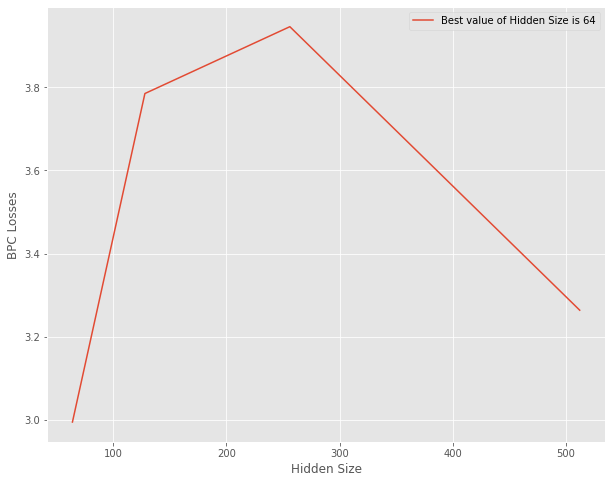

In [ ]:
plt.figure(figsize = (10,8))
plt.style.use("ggplot")
plt.plot(hs, loss_hs, label = "Best value of Hidden Size is "+ str(best_hidden_size))
plt.xlabel("Hidden Size")
plt.ylabel("BPC Losses")
plt.legend()

In [ ]:
len(all_losses[1])

50

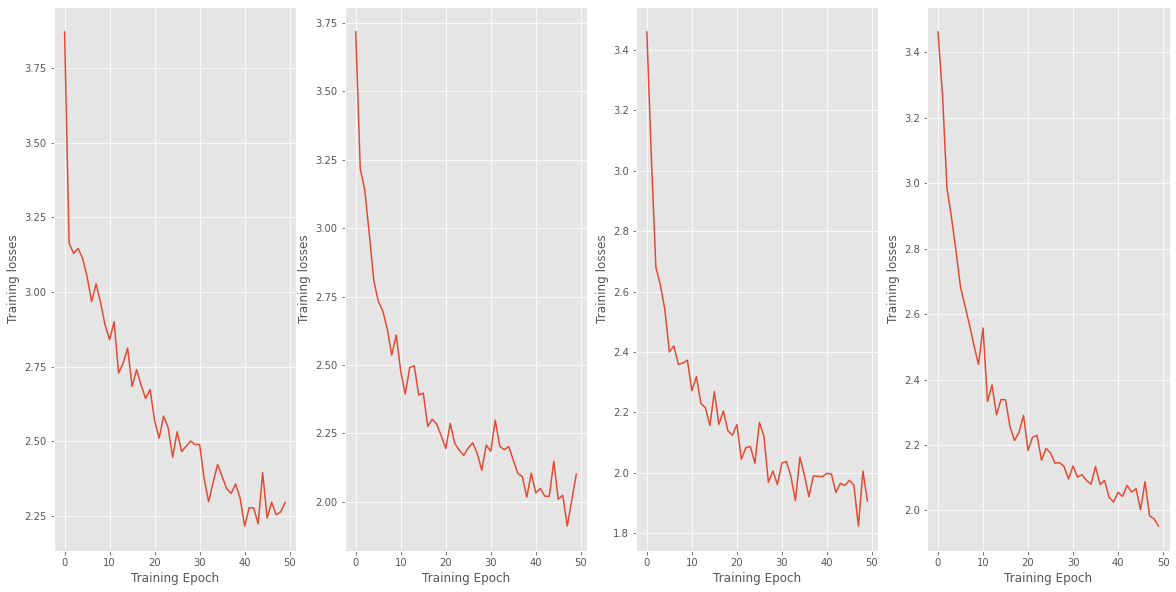

In [ ]:
fig, ax = plt.subplots(1, len(hs), figsize = (20,10))
for i in range(len(hs)):
  xx = np.arange(len(all_losses[i]))
  ax[i].plot(xx, all_losses[i])
  ax[i].set_xlabel("Training Epoch")
  ax[i].set_ylabel("Training losses")

In [ ]:
def tune_learning_rate(lr):
  n_epochs = 500
  print_every = 100
  plot_every = 10
  n_layers = 2
  hidden_size = 64
  loss_lr = []
  loss_avg = 0
  all_losses = [[] for _ in range(len(lr))]
  for i, learn_rate in enumerate(lr):
    decoder = LSTM(n_characters, hidden_size, n_characters, n_layers)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learn_rate)
    criterion = nn.CrossEntropyLoss()
    start = time.time()
    file = unidecode.unidecode(open('dickens_train.txt').read())


    for epoch in range(1, n_epochs+1):
        loss = train(decoder, decoder_optimizer, *random_training_set())
        loss_avg += loss

        if epoch % print_every == 0:
            print('[{} ({} {}%) {:.4f}]'.format(time_since(start), epoch, epoch/n_epochs * 100, loss))
            #print(generate(decoder, 'A', 100), '\n')

        if epoch % plot_every == 0:
            all_losses[i].append(loss_avg/ plot_every)
            loss_avg = 0

    file = unidecode.unidecode(open('dickens_test.txt').read())
    test, label = random_training_set()
    hidden = (decoder.h0, decoder.c0)
    loss_lr.append(bpc_loss(test, label, hidden, decoder))
    print("BPC loss here is ", loss_lr[-1])
  
  
  loss_lr = np.asarray(loss_lr)
  print("loss_lr is ", loss_lr)
  ii = np.argmin(loss_lr)
  best_lr = lr[ii]
  print("The best value for learning rate is ", best_lr)


  # plt.figure(figsize = (10,8))
  # plt.style.use("ggplot")
  # plt.plot(hs, loss_hs)
  # plt.xlabel("Hidden Size")
  # plt.ylabel("Respective Losses")
  return loss_lr, all_losses, best_lr

In [ ]:
lr = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.5])
loss_lr, all_losses_lr, best_lr = tune_learning_rate(lr)

 18s (100 20.0%) 3.1359]
 37s (200 40.0%) 3.4786]
 55s (300 60.0%) 2.7961]
 14s (400 80.0%) 2.7337]
 32s (500 100.0%) 2.7346]
BPC loss here is  2.6410706


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


 18s (100 20.0%) 2.6461]
 37s (200 40.0%) 2.3900]
 56s (300 60.0%) 2.2650]
 15s (400 80.0%) 2.2136]
 34s (500 100.0%) 2.2973]
BPC loss here is  2.696219
 18s (100 20.0%) 2.7139]
 36s (200 40.0%) 2.3578]
 54s (300 60.0%) 2.1963]
 13s (400 80.0%) 2.1790]
 31s (500 100.0%) 2.1608]
BPC loss here is  3.8844652
 18s (100 20.0%) 2.7191]
 36s (200 40.0%) 2.4443]
 56s (300 60.0%) 2.2232]
 16s (400 80.0%) 2.1920]
 37s (500 100.0%) 2.4180]
BPC loss here is  3.704106
 19s (100 20.0%) 2.3275]
 40s (200 40.0%) 2.2949]
 3s (300 60.0%) 2.7923]
 26s (400 80.0%) 2.4795]
 49s (500 100.0%) 2.2961]
BPC loss here is  3.2864456
 24s (100 20.0%) 3.1928]
 48s (200 40.0%) 2.7268]
 11s (300 60.0%) 3.3195]
 35s (400 80.0%) 2.9107]
 58s (500 100.0%) 3.0558]
BPC loss here is  2.972654
loss_lr is  [2.6410706 2.696219  3.8844652 3.704106  3.2864456 2.972654 ]
The best value for learning rate is  0.001


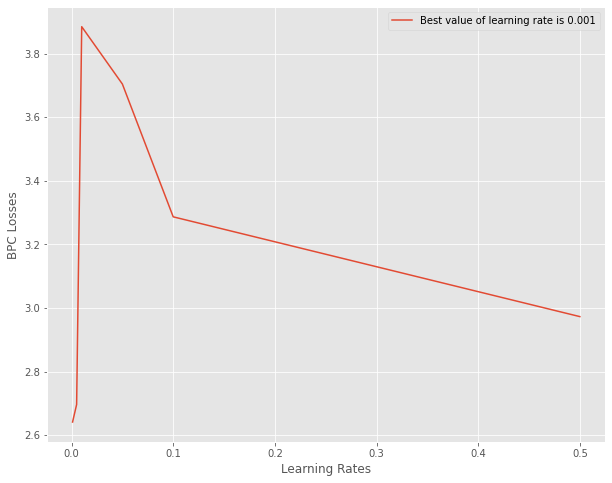

In [ ]:
plt.figure(figsize = (10,8))
plt.style.use("ggplot")
plt.plot(lr, loss_lr, label = "Best value of learning rate is "+ str(best_lr))
plt.xlabel("Learning Rates")
plt.ylabel("BPC Losses")
plt.legend()

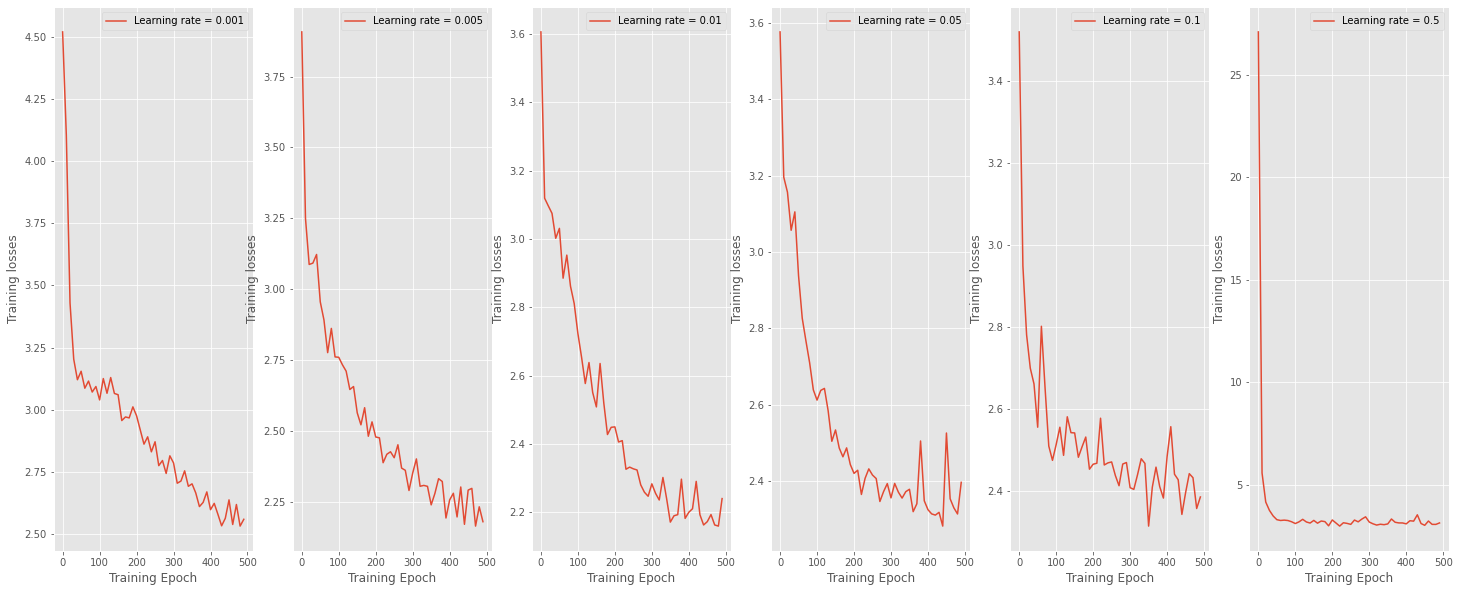

In [ ]:
fig, ax = plt.subplots(1, len(lr), figsize = (25,10))
for i in range(len(lr)):
  xx = np.arange(len(all_losses_lr[i]))*10
  ax[i].plot(xx, all_losses_lr[i], label = "Learning rate = " + str(lr[i]))
  ax[i].set_xlabel("Training Epoch")
  ax[i].set_ylabel("Training losses")
  ax[i].legend()

# Plotting the Training Losses (20 points)


<div class="alert alert-block alert-info">
An important aspect of deep network training task is visualization. Visualizing the training loss values would be helpful for debugging the system. For instance, at extremes, a learning rate that is too large will result in weight updates that will be too large and the performance of the model (such as its loss on the training dataset) will oscillate over training epochs. You would set the learning rate which do not cause oscillation with the help of visual charts.
    
In this exercise, we ask you to add the loss charts of experiments with different learning rates on the same graph and plot the graph. Add an entry for each experiment to the legend of the graph. If there is more than 10 experiments, use more than 1 chart (up to 10 experiments for each chart).

</div>

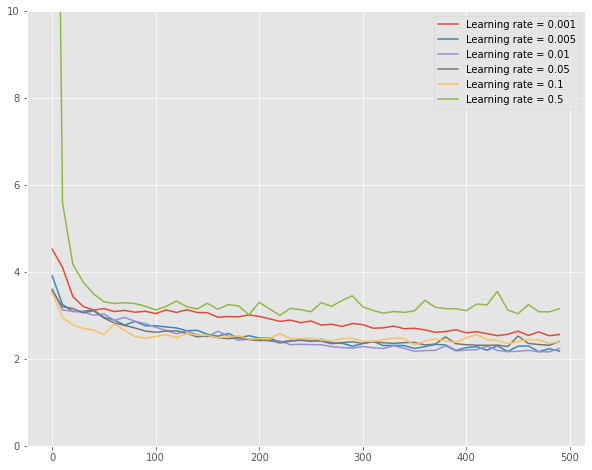

In [ ]:
#student solution/discussion here
plt.figure(figsize= (10,8))
for i in range(len(lr)):
  xx = np.arange(len(all_losses_lr[i]))*10
  plt.plot(xx, all_losses_lr[i], label = "Learning rate = "+ str(lr[i]))
  plt.ylim((0,10))
plt.legend()

# Generating at different "temperatures" (20 points)

<div class="alert alert-block alert-info">

In the `generate` function above, every time a prediction is made, the outputs are divided by the "temperature" argument passed. 

Generate strings by using different `temperature` values and evaluate the results qualitatively. Create chunks from the test set (200 character length as above) and take the first 10 characters of a randomly chosen chunk as a priming string.
What you observe in the output when you increase the `temperature` values? **In your understanding**, why does changing the temperature affect the output as the way you observed?
</div>

In [14]:
file = unidecode.unidecode(open('dickens_test.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 5476


In [15]:
#student solution/discussion here
temper = np.array([0.2, 0.4, 0.6, 0.8])
n_epochs = 500
print_every = 100
plot_every = 10
hidden_size = 64
n_layers = 2
lr = 0.001
for i, temp in enumerate(temper):
  print("############## \n")
  print(f"\n For temperature = {temp}: \n")
  decoder = LSTM(n_characters, hidden_size, n_characters, n_layers)
  decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()


  start = time.time()
  all_losses_temp = [[] for _ in range(len(temper))]
  loss_avg = 0
  chars = np.array([c for c in all_characters])

  for epoch in range(1, n_epochs+1):
      text, label = random_training_set()
      loss = train(decoder, decoder_optimizer, text, label)
      loss_avg += loss

      if epoch % print_every == 0:
          print('[{} ({} {}%) {:.4f}]'.format(time_since(start), epoch, epoch/n_epochs * 100, loss))
          pr = "".join(chars[text[:10]])
          print(generate(decoder, pr, 100, temp), '\n')

      if epoch % plot_every == 0:
          all_losses_temp[i].append(loss_avg/ plot_every)
          loss_avg = 0

############## 


 For temperature = 0.2: 

 19s (100 20.0%) 3.1178]
at I had
f          e  t             e      e           e    ee r ae  e    e    t            e      ee     a   

 40s (200 40.0%) 2.7644]
 of that
n h ao oe  a oe ot he an at he ae at ot aa an n er ot e aa ao at a te an  o an o aa an ho an aa at at 

 0s (300 60.0%) 2.6616]
harles the an sen an an an an an an an won an an on an an an an an he te an an te an on he on tan an an ton an 

 20s (400 80.0%) 2.5490]
ily observe an ton an ton tot an an an an an an or he tet an ton an the ton on an an on he he won on me tor an 

 39s (500 100.0%) 2.4794]
rify him.  an ton an an the tere the ton he the so ton an and an ton an tor and an the ton the the the the ton 

############## 


 For temperature = 0.4: 

 19s (100 20.0%) 3.1327]
nd rewardsn   o t d   ta   aeo oaae   nni aa ooe ee tnrhe e   o eeoa neeeaet dmduo t aens t  e a n  e i i    e 

 38s (200 40.0%) 3.0671]

and I und  e o  eo t eted e e ra eo  a  agha o  i  oh ee  

At lower temperature values, an untrained model tries to repeadily produce same characters beacuse lower temperature results in higher softmax values, easily triggering the neurons and making it less likely to sample from unlikely character candidates. However, higher temperature values produce softer probability distribution of output candidates resulting in more randomness while sampling and hence may end up with high error percentage

(If you still have energy / time left once you've reached this place here, try using other datasets (other texts; other types of text, like for example the Linux source code), other layers (e.g., a GRU instead of LSTM), etc. etc..) (**bonus question**)